In [1]:
%load_ext autoreload
%autoreload 2
import jax
import jax.numpy as jnp
from sparse_wf.model.wave_function import MoonLikeWaveFunction
from sparse_wf.system import get_molecule
from sparse_wf.mcmc import init_electrons

In [2]:
molecule_args = {"method": "chain", "chain_args": {"element": "H", "distance": 1.8, "n": 200}, "basis": "sto-3g"}
model_args = data = {
    "n_determinants": 16,
    "embedding": {
        "embedding": "new",
        "new": {
            "cutoff": 10.0,
            "feature_dim": 256,
            "nuc_mlp_depth": 4,
            "pair_mlp_widths": [16, 8],
            "pair_n_envelopes": 32,
            "cutoff_1el": 20.0,
            "low_rank_buffer": 1,
            "n_updates": 1,
        },
    },
    "jastrow": {
        "e_e_cusps": "psiformer",
        "use_log_jastrow": True,
        "use_mlp_jastrow": True,
        "mlp_depth": 2,
        "mlp_width": 64,
    },
    "envelopes": {"envelope": "isotropic", "isotropic_args": {"n_envelopes": 8}},
}
mol = get_molecule(molecule_args)
wf = MoonLikeWaveFunction.create(mol, **model_args)

In [3]:
key = jax.random.PRNGKey(42)
key, subkey = jax.random.split(key)
electrons = init_electrons(key, mol, 1)[0]
params = wf.init(subkey, electrons)

2024-07-28 14:35:15.401258: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [43]:
static = wf.get_static_input(electrons)
static = jax.tree_util.tree_map(int, static)
logpsi, state = wf.log_psi_with_state(params, electrons, static)

In [44]:
idx = 11


@jax.jit
@jax.vmap
def low_rank(delta):
    inp = electrons.at[idx, 0].add(delta)
    return wf.log_psi_low_rank_update(params, inp, jnp.array([idx]), static, state)[0]


@jax.jit
@jax.vmap
def full_rank(delta):
    inp = electrons.at[idx, 0].add(delta)
    return wf.log_psi_with_state(params, inp, static)[0]

In [45]:
d = jnp.linspace(0, 12, 32)
low_rank_values = low_rank(d)[1]
full_rank_values = full_rank(d)[1]

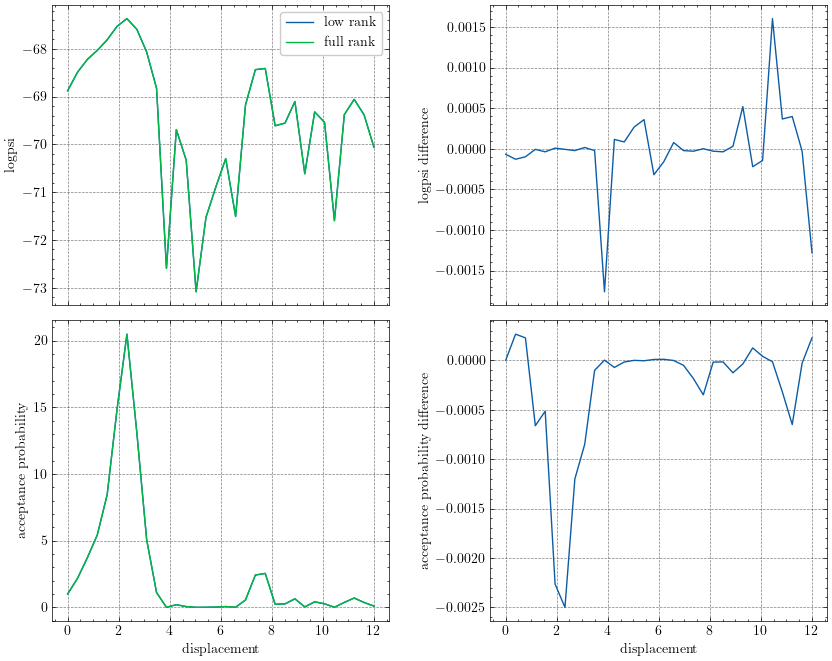

In [46]:
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(["science", "grid"])
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
ax1, ax2, ax3, ax4 = axes.ravel()
ax1.plot(d, low_rank_values, label="low rank")
ax1.plot(d, full_rank_values, label="full rank")
ax1.legend()
ax1.set_ylabel("logpsi")

ax2.plot(d, low_rank_values - full_rank_values)
ax2.set_ylabel("logpsi difference")

full_acc_prob = jnp.exp(2 * (full_rank_values - full_rank_values[0]))
low_acc_prob = jnp.exp(2 * (low_rank_values - low_rank_values[0]))
ax3.plot(d, full_acc_prob, label="full rank")
ax3.plot(d, low_acc_prob, label="low rank")
ax3.set_xlabel("displacement")
ax3.set_ylabel("acceptance probability")

ax4.plot(d, full_acc_prob - low_acc_prob, label="full rank")
ax4.set_xlabel("displacement")
ax4.set_ylabel("acceptance probability difference")
plt.subplots_adjust(wspace=0.3, hspace=0.05)
plt.show()

In [ ]:
new_logpsi, new_state = wf.log_psi_log_rank_update(params, electrons + delta, changed_idx, static, state)

In [ ]:
real_logpsi, real_state = wf.logpsi_with_state(params, electrons + delta, static)

In [ ]:
jax.tree_map(lambda x, y: jnp.linalg.norm(x - y), new_state, real_state)

LowRankState(embedding=MoonState(h_init=Array(5.725775e-06, dtype=float32), h_init_same=Array(4.608208e-06, dtype=float32), h_init_diff=Array(4.3262476e-06, dtype=float32), h0=Array(7.916396, dtype=float32), h1=Array(3.8104386, dtype=float32), HL_up=Array(17.593645, dtype=float32), HL_dn=Array(16.840382, dtype=float32), h_out=Array(3.3669188, dtype=float32)), orbitals=OrbitalState(envelopes=Array(4.350057e-06, dtype=float32), orbitals=Array(2.246044, dtype=float32)), determinant=LogPsiState(matrices=(Array(2.246044, dtype=float32),), inverses=[Array(11578.306, dtype=float32)], slogdets=[(Array(2., dtype=float32), Array(3.996781, dtype=float32))]), jastrow=Array(0.08887396, dtype=float32))

In [ ]:
(new_logpsi - real_logpsi), (new_logpsi - real_logpsi) / real_logpsi, real_logpsi, new_logpsi, logpsi

(Array(1.1938934, dtype=float32),
 Array(-0.00869305, dtype=float32),
 Array(-137.33891, dtype=float32),
 Array(-136.14502, dtype=float32),
 Array(-135.126, dtype=float32))

# Benchmarking

In [52]:
electrons = init_electrons(key, mol, 64)

In [53]:
import functools


@functools.partial(jax.jit, static_argnums=1)
@functools.partial(jax.vmap, in_axes=(0, None))
def normal_fwd(electrons, static):
    return wf.log_psi_with_state(params, electrons, static)[0]

In [54]:
static = wf.get_static_input(electrons)
static = jax.tree_util.tree_map(int, static)
%time jax.block_until_ready(normal_fwd(electrons, static));
%timeit jax.block_until_ready(normal_fwd(electrons, static));

CPU times: user 5.12 s, sys: 237 ms, total: 5.36 s
Wall time: 5.75 s
154 ms ± 37 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [59]:
import functools


@functools.partial(jax.jit, static_argnums=1)
@functools.partial(jax.vmap, in_axes=(0, None, 0))
def fast_fwd(electrons, static, state):
    return wf.log_psi_low_rank_update(params, electrons, jnp.array([0]), static, state)

In [60]:
static = wf.get_static_input(electrons)
static = jax.tree_util.tree_map(int, static)
_, state = jax.vmap(wf.log_psi_with_state, in_axes=(None, 0, None))(params, electrons, static)
%time jax.block_until_ready(fast_fwd(electrons, static, state));
%timeit jax.block_until_ready(fast_fwd(electrons, static, state));

CPU times: user 3.11 s, sys: 176 ms, total: 3.29 s
Wall time: 3.57 s
29.4 ms ± 113 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
normal_fwd(electrons, static) - fast_fwd(electrons, static, state)[0]

Array([-3.0517578e-05, -1.5258789e-05, -1.5258789e-05, -3.0517578e-05,
       -3.0517578e-05,  0.0000000e+00,  1.5258789e-05,  0.0000000e+00,
        7.6293945e-05, -3.0517578e-05,  1.9989014e-03,  0.0000000e+00,
        4.5776367e-05, -1.5258789e-05,  1.5258789e-04,  1.5258789e-05,
        0.0000000e+00, -4.5776367e-05,  0.0000000e+00,  3.0517578e-05,
        7.6293945e-05,  0.0000000e+00,  7.6293945e-06,  0.0000000e+00,
        2.1362305e-04, -1.5258789e-05,  4.5776367e-05,  1.5258789e-05,
        3.6468506e-03,  3.0517578e-05,  1.5258789e-05, -9.9182129e-05],      dtype=float32)

5ms - full

1.62ms - embedding

2.9ms - orbitals

2.47ms - logdet

2.5ms - logpsi

5.17ms - full